In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

## Creating delivary locations

In [101]:
def create_delivary(x,y,n):
    x_range = [x[0], y[0]]
    y_range = [x[1], y[1]]
    loc = []

    for i in range(n):
        x_loc = random.uniform(x_range[0], x_range[1])
        y_loc = random.uniform(y_range[0], y_range[1])
        loc.append([x_loc, y_loc])

    return loc

## Visualizations

In [102]:
def primary_plot(delivary_loc, obstacles):
    delivary_loc = np.array(delivary_loc)
    plt.grid(True)
    plt.scatter(delivary_loc[:,0], delivary_loc[:,1], label="Delivary loc")

    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        # points = np.array(points)
        # plt.scatter(points[:,0], points[:,1])
        plt.fill(x,y,color="red", alpha = 0.7)
    # plt.legend()

In [103]:
def plot_dp(dp, delivary_loc, obstacles):
    primary_plot(delivary_loc, obstacles)
    plt.scatter(dp[0], dp[1], marker='^', c="black", label = "DP")
    # plt.legend()
    # plt.show()

In [104]:
def plot_initial_route(dp, delivary_loc, obstacles, route, title=None):
    plot_dp(dp, delivary_loc, obstacles)
    for i in range(len(route)-1):
        f_pt = np.array([route[i][0], route[i+1][0]])
        s_pt = np.array([route[i][1], route[i+1][1]])
        plt.plot(f_pt, s_pt, c="gray")
    if title != None:
        plt.title(title)
    # plt.show()

## Calculate DP

In [105]:
def calculate_dp(delivary_loc):
    x = [i for i,j in delivary_loc]
    y = [j for i,j in delivary_loc]

    x_axis = np.mean(x)
    y_axis = np.mean(y)

    return [x_axis, y_axis]

## Create Route

In [106]:
def create_route(pts, extra):
    lst = pts.copy()
    idx = 0
    k = len(lst)
    for i in range(k):
        lst.insert(idx, extra)
        idx +=2

    lst.append(extra)
    return lst

## Distance Calculate

In [107]:
def euc_distance(pt1, pt2):
    pt1 = np.array(pt1)
    pt2 = np.array(pt2)
    return np.sqrt(np.sum((pt2 - pt1)**2))

In [108]:
def total_dist(pts):
    sum = 0
    for i in range(len(pts)-1):
        sum += euc_distance(pts[i], pts[i+1])

    return sum

## Check for obstacles

In [109]:
from shapely.geometry import LineString, Polygon, Point

def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [110]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle_id, points in obstacles.items():
    obstacle = create_polygon(points)
    if line.intersects(obstacle):
      return True

  return False

In [111]:
def detect_obstacle(route, obstacles):
    for i in range(0,len(route)-1,2):
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            return True
    return False

## Generate Intermediate Point

In [112]:
def is_obstacle_free(line, obstacles):
    for obs_id, obs in obstacles.items():
        if line.intersects(obs):
            return False
    return True

In [113]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = {id_: create_polygon(points) for id_, points in obstacles.items()}
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle_id, obstacle in obstacle_polygons.items():
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.3
    increment = 0.3
    limit = 2.5

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        # if not left_side.intersects(target_obs):
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs_id, obs in obstacle_polygons.items():
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        # if not right_side.intersects(target_obs):
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs_id, obs in obstacle_polygons.items():
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        # if not up_side.intersects(target_obs):
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs_id, obs in obstacle_polygons.items():
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        # if not down_side.intersects(target_obs):
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs_id, obs in obstacle_polygons.items():
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

In [114]:
def adv_route(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)-1):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            intermediate_point = find_inter_point(route[i], route[i+1], obstacles)
            if intermediate_point == None:
                return route, "fail"
            ans_route.append(route[i])
            ans_route.append(intermediate_point)
            ans_route.append(route[i+1])
            ans_route.append(intermediate_point)
        else:
            ans_route.append(route[i])
            ans_route.append(route[i+1])

    ans_route.append(dp)
    return ans_route, "pass"

## A* Algorithm

In [115]:
import networkx as nx
from shapely.affinity import translate

In [116]:
def line_intersect(line, obstacle):
    points = line.intersection(obstacle)
    
    if(type(points) != Point and type(points) != LineString):
        return True
    
    if len(points.coords) == 0 or len(points.coords) == 1:
        return False

    points = [pt for pt in points.coords]
    obstacle_points = [pt for pt in obstacle.exterior.coords[:-1]]

    try :
        index_list = [obstacle_points.index(i) for i in points]
    except:
        return True

    for i in range(0,len(index_list)-1,2):
        if not (abs(index_list[i] - index_list[i+1]) == 1 or abs(index_list[i] - index_list[i+1]) == len(obstacle_points)-1):
            return True

    return False

In [117]:
def check_for_obstacle(point_1, point_2, obstacles):
    line = LineString([point_1, point_2])

    for obs_id, obs in obstacles.items():
        # if line.intersects(obs):
        if line_intersect(line, obs):
            return True
    return False

In [118]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [119]:
def create_shortest_path(point_1, point_2, obstacles):
    obstacle_polygon = {ob_id : create_polygon(obs) for ob_id, obs in obstacles.items()}
    route_line = LineString([point_1, point_2])

    # print("Initial polygon ",obstacle_polygon)

    intersections = []
    for obstacle_id, obstacle in obstacle_polygon.items():
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])
    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))

    G.add_node(tuple(point_2))
    
    # create new polygon
    # for obs_id, obstacle in obstacle_polygon.items():
    #     obstacle_polygon[obs_id] = scale_polygon(obstacle)
    
    # print("New polygon ",obstacle_polygon)

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            if not check_for_obstacle(cur, next, obstacle_polygon):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=euc_distance)
    # print("Path cost :",nx.astar_path_length(G,start,goal, heuristic=euc_distance))

    # Plotting the graph with obstacles and path
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color='lightgray', with_labels=False)
    nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    plt.title('Path Planning with Obstacle Avoidance')
    plt.show()

    return path

In [120]:
def a_star_algo(route, dp, obstacles):
    ans_route = []
    for i in range(len(route)-1):
        if route[i] != dp:
            continue
        if check_obstacle_in_line(route[i],route[i+1], obstacles):
            new_path = create_shortest_path(route[i], route[i+1], obstacles)
            if new_path == None:
                return route, "fail"
            for i in new_path:
                ans_route.append(i)
            for i in range(len(new_path)-2, 0, -1):
                ans_route.append(new_path[i])
        else:
            ans_route.append(route[i])
            ans_route.append(route[i+1])

    ans_route.append(dp)
    return ans_route, "pass"

## Creation of New DP

In [121]:
def replace(lst, pt1, pt2):
    ls2 = lst.copy()
    for i in range(len(ls2)):
        if ls2[i] == pt1:
            ls2[i] = pt2

    return ls2

In [122]:
def frange(start, stop, step):
    while start < stop:
        yield round(start, 4)
        start += step

In [123]:
def calculate_obstacle_free_dp(delivery_loc, obstacles, dp):
    
    # Initialize potential DP locations (covering the delivery point area)
    min_x = dp[0] - 1.0
    max_x = dp[0] + 1.0
    min_y = dp[1] - 1.0
    max_y = dp[1] + 1.0

    potential_dps = {}
    for x in frange(min_x, max_x, 0.2):
        for y in frange(min_y, max_y, 0.2):
            potential_dps[x,y] = {
                'route' : [],
                'distance' : 0
            }

    # Evaluate each potential DP and filter out those obstructed by obstacles
    for each_dp, value in potential_dps.items():
        first_route = create_route(delivery_loc, each_dp)
        last_route,msg = a_star_algo(first_route,each_dp,obstacles)
        if msg == 'pass':
            distance = total_dist(last_route)
        else:
            distance = float('inf')
        potential_dps[each_dp]['route'] = last_route
        potential_dps[each_dp]['distance'] = distance

    answer = min(potential_dps, key = lambda x : potential_dps[x]['distance'])

    return answer,potential_dps[answer]['route'],potential_dps[answer]['distance']

## Remove delivary points that are in the obstacles

In [124]:
def remove_obstacle(delivary_loc, obstacles):
    obstacle_polygon = {obs_id : create_polygon(obs) for obs_id, obs in obstacles.items()}
    delivary_point = [Point([a,b]) for a,b in delivary_loc]
    final_point = []
    
    for point in delivary_point:
        flag = True
        for obs_id, obs in obstacle_polygon.items():
            if (point.intersects(obs)):
                flag = False
                break
        if flag:
            final_point.append([point.x, point.y])
    return final_point

## Main

In [125]:
# pre-assumptions
x = [22.21, 88.45]
y = [32.45, 98.67]
n = 20

# answers
optimal_dp = []
optimal_route = []

# Creating delivary points
delivary_loc = create_delivary(x,y,n)

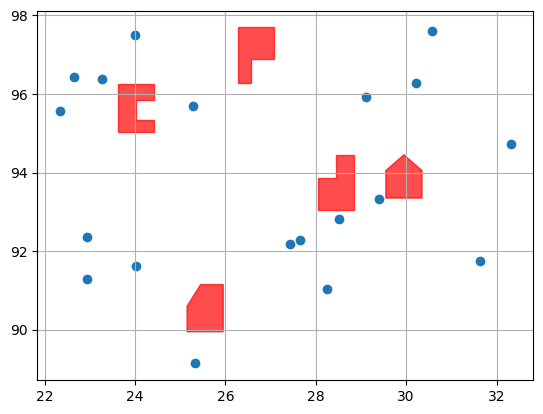

In [126]:
# creating obstacles
obstacles = {
    0 : [[28.05, 93.05],[28.85, 93.05],[28.85, 94.45], [28.45, 94.45], [28.45, 93.85],[28.05, 93.85],[28.05, 93.05]],
    1 : [[25.15, 89.95],[25.95, 89.95],[25.95, 91.15], [25.45, 91.15], [25.15, 90.60],[25.15, 89.95]],
    2 : [[26.27, 96.29],[26.57, 96.29],[26.57, 96.89], [27.07, 96.89],[27.07, 97.69], [26.27, 97.69], [26.27, 96.29]],
    3 : [[23.62, 95.04],[24.42, 95.04],[24.42, 95.34], [24.02, 95.34], [24.02, 95.84],[24.42, 95.84],[24.42, 96.24],[23.62, 96.24],[23.62, 95.04]],
    4 : [[29.55, 93.35],[30.35, 93.35],[30.35, 94.05], [29.95, 94.45], [29.55, 94.05], [29.55, 93.35]],
}

delivary_loc = remove_obstacle(delivary_loc, obstacles)

primary_plot(delivary_loc, obstacles)

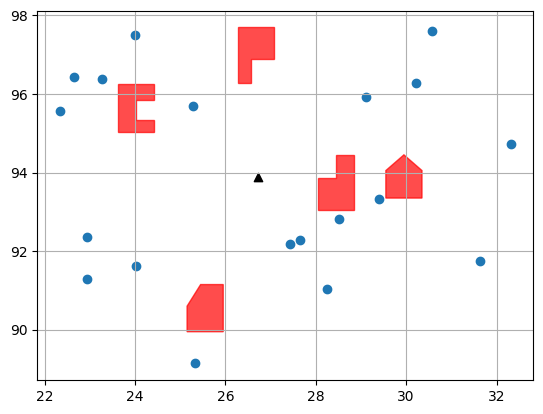

In [127]:
# creating initial dp
initial_dp = calculate_dp(delivary_loc)

# visualize dp
plot_dp(initial_dp, delivary_loc, obstacles)

*calculate total distance from the initial dp*

In [128]:
# calculate route
initial_route = create_route(delivary_loc,initial_dp)

for i in initial_route:
    print(i,"->",end=" ")
print("End")

[26.728871670990895, 93.89146745644341] -> [29.39978195730789, 93.31504670315964] -> [26.728871670990895, 93.89146745644341] -> [25.290790872028573, 95.69449453886247] -> [26.728871670990895, 93.89146745644341] -> [22.930863515583606, 92.35387625974188] -> [26.728871670990895, 93.89146745644341] -> [27.65890917919741, 92.28551372336216] -> [26.728871670990895, 93.89146745644341] -> [24.023126825530852, 91.61395132483352] -> [26.728871670990895, 93.89146745644341] -> [23.26300520095789, 96.38948112934712] -> [26.728871670990895, 93.89146745644341] -> [27.422064078853992, 92.18570483601842] -> [26.728871670990895, 93.89146745644341] -> [22.939986342698916, 91.28852336309151] -> [26.728871670990895, 93.89146745644341] -> [31.63384097550223, 91.76150324187728] -> [26.728871670990895, 93.89146745644341] -> [23.98771914244144, 97.49911145640517] -> [26.728871670990895, 93.89146745644341] -> [25.322214760886293, 89.14213450988792] -> [26.728871670990895, 93.89146745644341] -> [22.649687753059

Initial Distance : 146.5073847971625


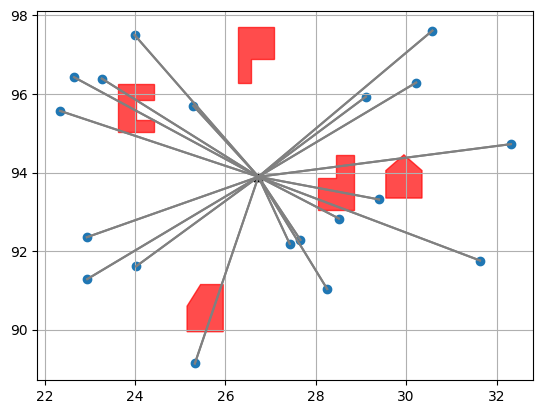

In [129]:
# calculating distance
initial_dist = total_dist(initial_route)

print("Initial Distance :",initial_dist)

# Visualization
plot_initial_route(initial_dp, delivary_loc, obstacles, initial_route)

*check for obstacles in the path, if no obstacle then it is optimal dp and optimal path*

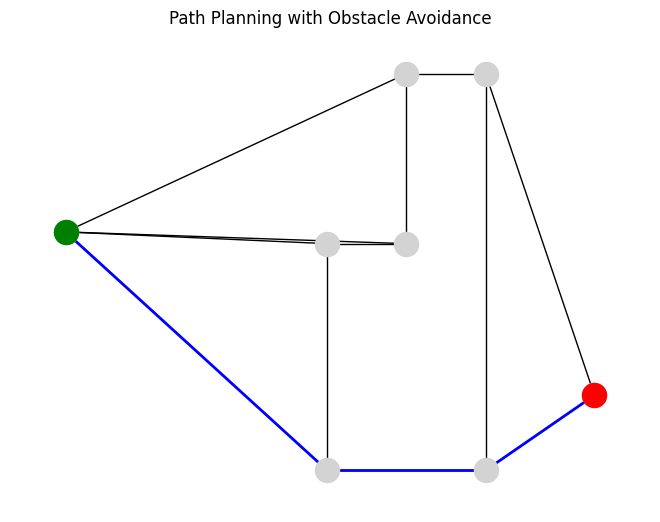

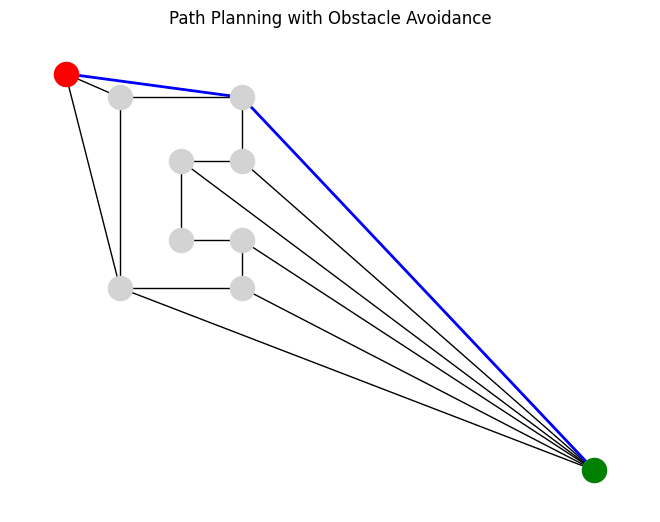

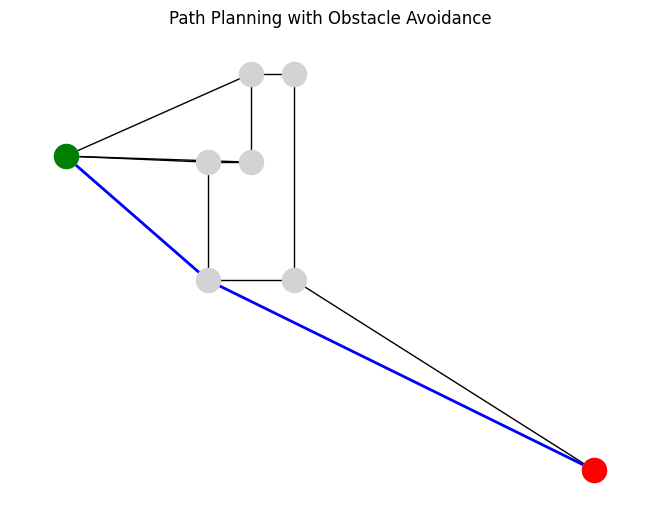

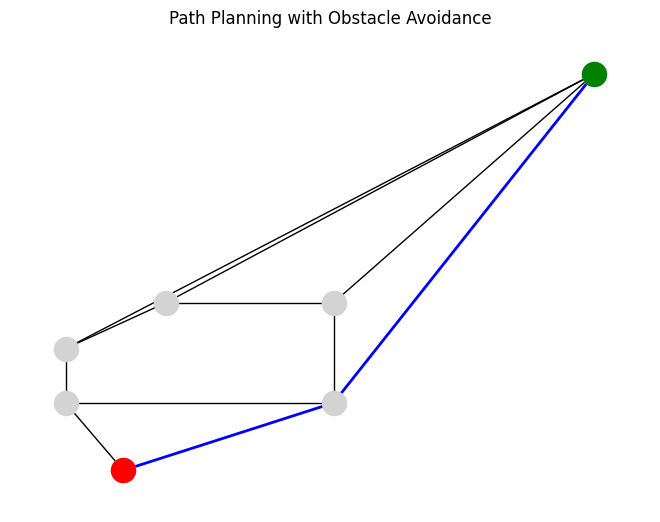

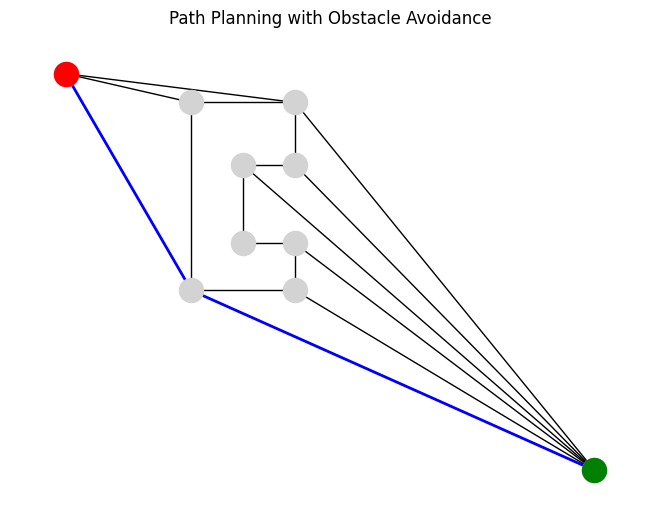

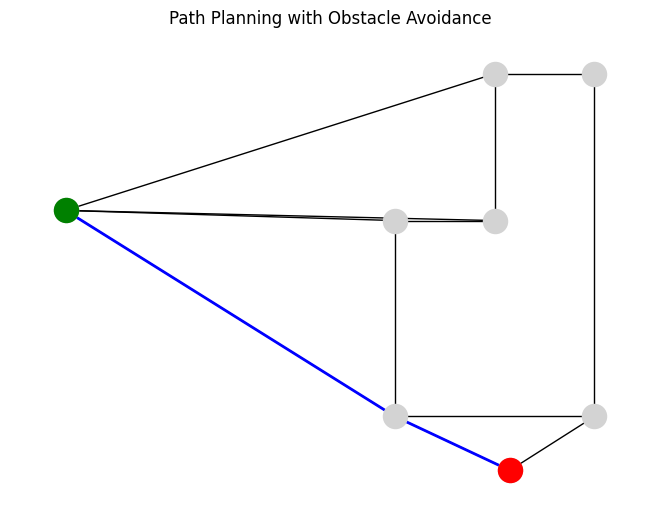

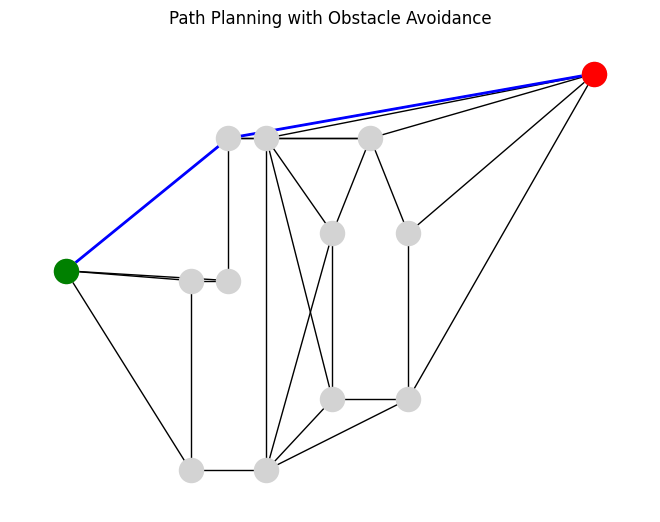

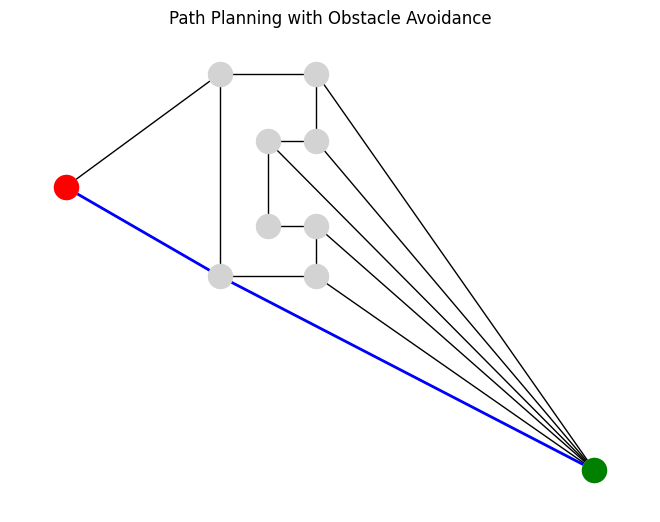

--------------------------------------------------
Obstacle avoidance =>
Dp = [26.728871670990895, 93.89146745644341]
Route = [(26.728871670990895, 93.89146745644341), (28.05, 93.05), (28.85, 93.05), (29.39978195730789, 93.31504670315964), (28.85, 93.05), (28.05, 93.05), [26.728871670990895, 93.89146745644341], [25.290790872028573, 95.69449453886247], [26.728871670990895, 93.89146745644341], [22.930863515583606, 92.35387625974188], [26.728871670990895, 93.89146745644341], [27.65890917919741, 92.28551372336216], [26.728871670990895, 93.89146745644341], [24.023126825530852, 91.61395132483352], (26.728871670990895, 93.89146745644341), (24.42, 96.24), (23.26300520095789, 96.38948112934712), (24.42, 96.24), [26.728871670990895, 93.89146745644341], [27.422064078853992, 92.18570483601842], [26.728871670990895, 93.89146745644341], [22.939986342698916, 91.28852336309151], (26.728871670990895, 93.89146745644341), (28.05, 93.05), (31.63384097550223, 91.76150324187728), (28.05, 93.05), [26.7288716

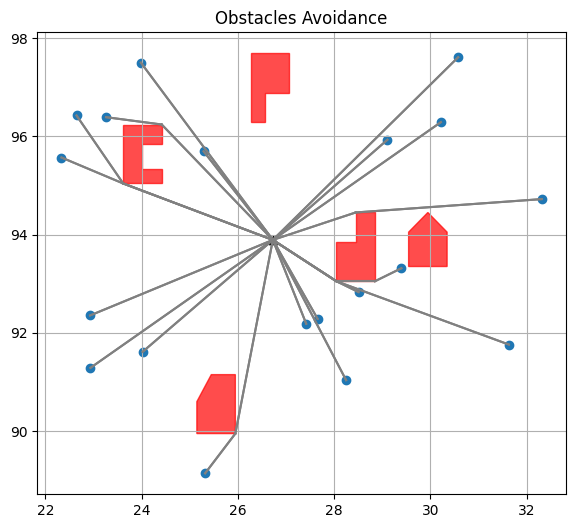

Optimal dp : [26.728871670990895, 93.89146745644341]
Optimal route : [(26.728871670990895, 93.89146745644341), (28.05, 93.05), (28.85, 93.05), (29.39978195730789, 93.31504670315964), (28.85, 93.05), (28.05, 93.05), [26.728871670990895, 93.89146745644341], [25.290790872028573, 95.69449453886247], [26.728871670990895, 93.89146745644341], [22.930863515583606, 92.35387625974188], [26.728871670990895, 93.89146745644341], [27.65890917919741, 92.28551372336216], [26.728871670990895, 93.89146745644341], [24.023126825530852, 91.61395132483352], (26.728871670990895, 93.89146745644341), (24.42, 96.24), (23.26300520095789, 96.38948112934712), (24.42, 96.24), [26.728871670990895, 93.89146745644341], [27.422064078853992, 92.18570483601842], [26.728871670990895, 93.89146745644341], [22.939986342698916, 91.28852336309151], (26.728871670990895, 93.89146745644341), (28.05, 93.05), (31.63384097550223, 91.76150324187728), (28.05, 93.05), [26.728871670990895, 93.89146745644341], [23.98771914244144, 97.4991

In [130]:
if(detect_obstacle(initial_route, obstacles)):

    # obstacle avoidance
    temp_route = initial_route.copy()
    new_route, msg = a_star_algo(temp_route, initial_dp, obstacles)
    if msg == "pass":
        new_dist = total_dist(new_route)
    else:
        new_dist = float('inf')
    print("-"*50)
    print("Obstacle avoidance =>")
    print("Dp =",initial_dp)
    print("Route =",new_route)
    print("Total distance =",new_dist)
    print("-"*50)

    # locate new dp
    final_dist = float('inf')
    final_route = []
    new_dp = 0.0
    # new_dp,final_route,final_dist = calculate_obstacle_free_dp(delivary_loc, obstacles, initial_dp)

    # print("Relocation of DP =>")
    # print("Dp =",new_dp)
    # print("Route =",final_route)
    # print("Total distance =",final_dist)
    # print("-"*50)

    # comparison
    if final_dist < new_dist:
        optimal_dp = new_dp
        optimal_route = final_route
    else:
        optimal_dp = initial_dp
        optimal_route = new_route

    # visual representation
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plot_initial_route(initial_dp,delivary_loc, obstacles, new_route, "Obstacles Avoidance")
    # plt.subplot(1,2,2)
    # plot_initial_route(new_dp,delivary_loc, obstacles, final_route, "Optimal DP")
    plt.show()
else:
    optimal_dp = initial_dp
    optimal_route = initial_route

print("Optimal dp :",optimal_dp)
print("Optimal route :",optimal_route)

## Result

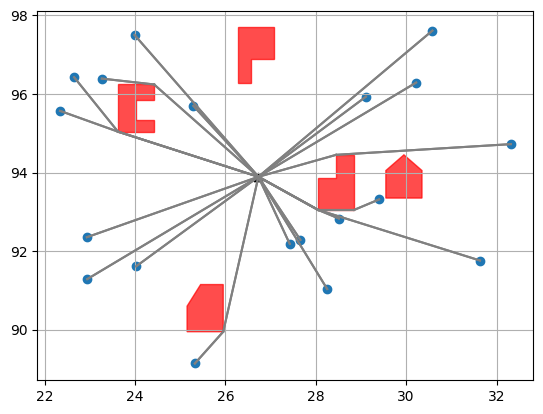

In [131]:
plot_initial_route(optimal_dp,delivary_loc, obstacles, optimal_route)

## Hold

#### Enhancement of dp

In [132]:
def enhance_dp(initial_route, obstacles):
    del_point = []
    obstacle_polygon = {obs_id : create_polygon(obs) for obs_id, obs in obstacles.items()}

    for pt in range(0,len(initial_route)-1,2):
        flag = True
        line = LineString([initial_route[pt],initial_route[pt+1]])
        for obs_id, obstacle in obstacle_polygon.items():
            if line.intersects(obstacle):
                point = line.intersection(obstacle)
                del_point.append(point.coords[0])
                flag = False
                break
        if flag:
            del_point.append(initial_route[pt+1])
    dp = calculate_dp(del_point)
    print("Initial DP :",initial_dp)
    return dp

In [133]:
enh_dp = enhance_dp(initial_route, obstacles)
print("New DP :",enh_dp)

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

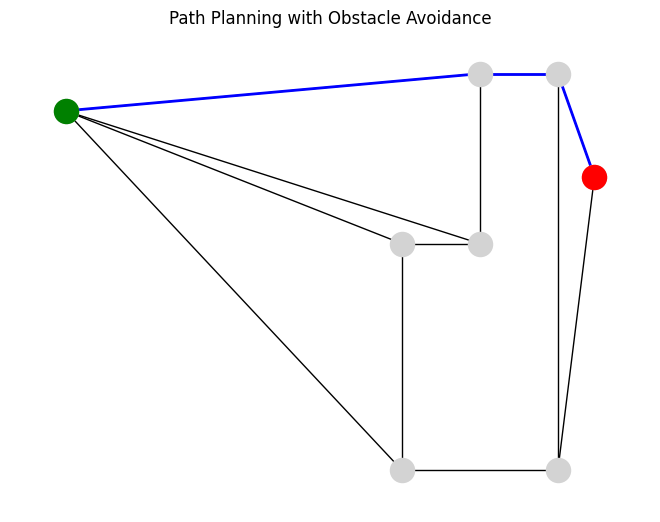

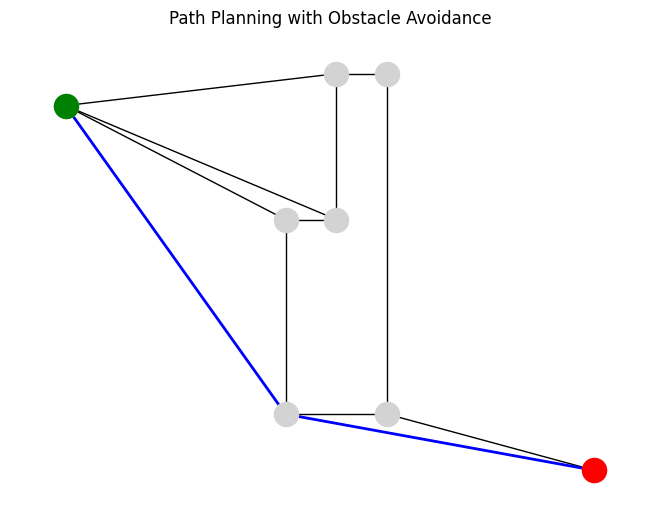

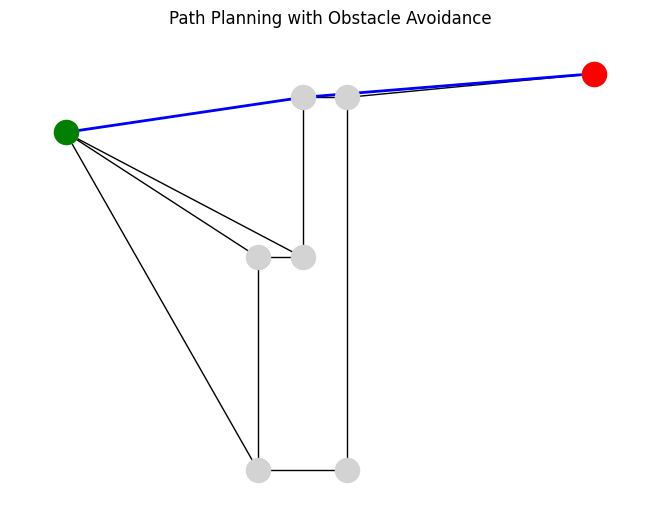

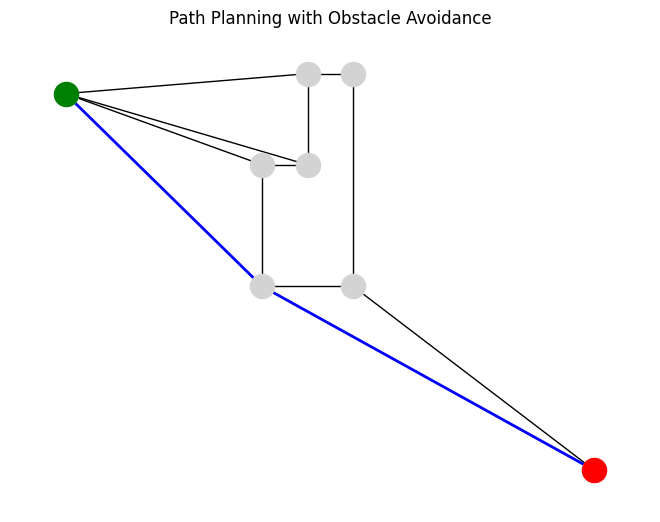

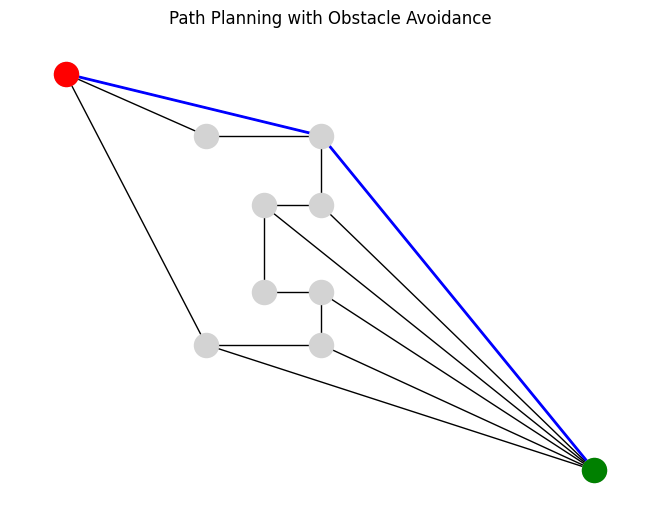

--------------------------------------------------
Obstacle avoidance =>
Dp = [26.667552180749677, 94.11389561075042]
Route = [(26.322072575041304, 94.31860858553327), (28.45, 94.45), (28.85, 94.45), (29.037920100922342, 94.08616014422299), (28.85, 94.45), (28.45, 94.45), [26.322072575041304, 94.31860858553327], [25.766701411573457, 94.39470513111978], [26.322072575041304, 94.31860858553327], [28.87355909378357, 97.5970309493374], [26.322072575041304, 94.31860858553327], [29.639313149025632, 95.26759953228239], [26.322072575041304, 94.31860858553327], [23.67123304983331, 92.50455196973606], [26.322072575041304, 94.31860858553327], [24.532816670848337, 88.73790793633927], (26.322072575041304, 94.31860858553327), (28.05, 93.05), (30.476337415470134, 92.81889970603055), (28.05, 93.05), [26.322072575041304, 94.31860858553327], [30.421063813106407, 95.43906437003935], [26.322072575041304, 94.31860858553327], [23.199636888268998, 90.07531124823095], [26.322072575041304, 94.31860858553327], [

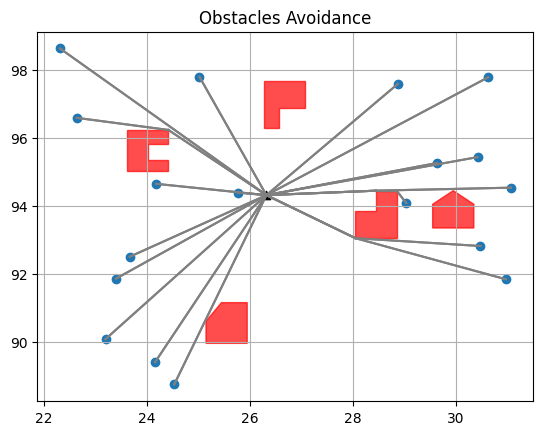

In [ ]:
temp_route = initial_route.copy()
temp_route = replace(initial_route, initial_dp, enh_dp)
new_route, msg = a_star_algo(temp_route, enh_dp, obstacles)
if msg == "pass":
    last_dist = total_dist(new_route)
else:
    last_dist = float('inf')
print("-"*50)
print("Obstacle avoidance =>")
print("Dp =",initial_dp)
print("Route =",new_route)
print("Total distance =",new_dist)
print("-"*50)

plot_initial_route(enh_dp,delivary_loc, obstacles, new_route, "Obstacles Avoidance")

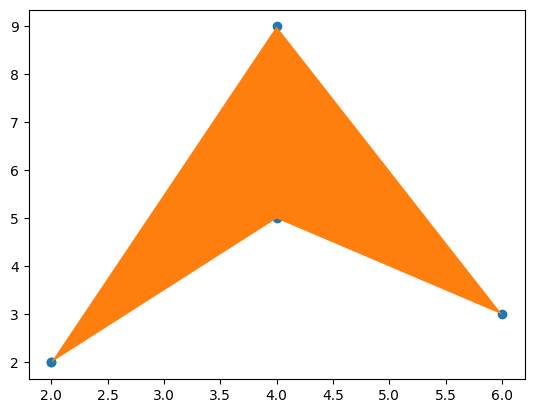

In [ ]:
points = [(2,2),(4,5),(6,3),(4,9),(2,2)]

x = [i for i,j in points]
y = [j for i,j in points]

points = np.array(points)
plt.scatter(points[:,0], points[:,1])
plt.fill(x,y)
plt.show()

In [ ]:
print(n)
print(len(obstacles))
print(initial_dist)
print(new_dist)
print(last_dist)

20
5
149.4755909695243
151.36828318840503
150.72324734971605


In [ ]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacles.csv')

new_row = {
    'delivary_locations':n,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_dist,
    'with_obstacle_distance':new_dist,
    'distance_after_dp_relocation':last_dist
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,with_obstacle_distance,distance_after_dp_relocation
48,35,5.0,5,92.487223,93.340217,NaN
49,47,5.0,5,120.675581,121.241933,NaN
50,43,5.0,5,102.835039,103.560903,NaN
51,20,NaN,5,136.175464,139.366194,141.177309
52,20,NaN,5,149.475591,151.368283,150.723247


In [ ]:
try:
    df.to_csv('./drone_performance_on_obstacles.csv', index=False)
except:
    print("Unknown error occurs")

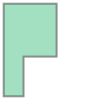

In [ ]:
coords = [[26.27, 96.29],[26.57, 96.29],[26.57, 96.89], [27.07, 96.89],[27.07, 97.69], [26.27, 97.69], [26.27, 96.29]]

pol = Polygon(coords)

pol

In [ ]:
center = pol.centroid

center.intersects(pol)

True

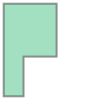

In [ ]:
pol_2 = scale_polygon(pol)

pol_2

In [ ]:
for i in pol.exterior.coords:
    print(i,end=" ")

(26.27, 96.29) (26.57, 96.29) (26.57, 96.89) (27.07, 96.89) (27.07, 97.69) (26.27, 97.69) (26.27, 96.29) 

In [ ]:
for i in pol_2.exterior.coords:
    print(i,end=" ")

(26.273451219512197, 96.29846341463416) (26.570451219512197, 96.29846341463416) (26.570451219512197, 96.89246341463415) (27.065451219512195, 96.89246341463415) (27.065451219512195, 97.68446341463414) (26.273451219512197, 97.68446341463414) (26.273451219512197, 96.29846341463416) 

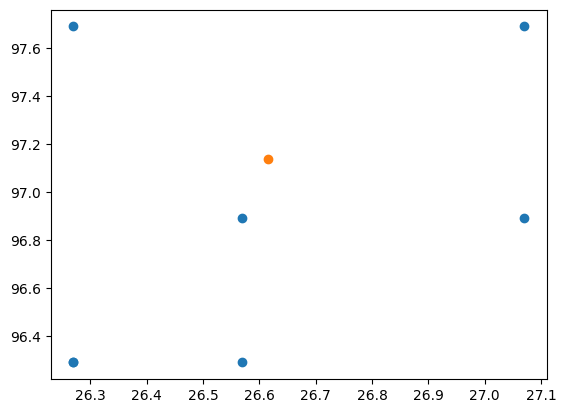

In [ ]:
coords = np.array(coords)
plt.scatter(coords[:,0],coords[:,1])
plt.scatter(center.x, center.y)

In [ ]:
def scale_polygon(polygon, scale_factor=0.99):
    centroid = polygon.centroid

    # Create a new polygon with reduced distance from the centroid
    new_points = []
    for p in polygon.exterior.coords:
        # Calculate the new coordinates based on the centroid, scale factor, and original coordinates
        new_x = centroid.x + (p[0] - centroid.x) * scale_factor
        new_y = centroid.y + (p[1] - centroid.y) * scale_factor
        new_points.append((new_x, new_y))

    new_polygon = Polygon(new_points)
    return new_polygon

# Test the function
polygon_points = [[26.27, 96.29], [26.57, 96.29], [26.57, 96.89], [27.07, 96.89], [27.07, 97.69], [26.27, 97.69], [26.27, 96.29]]
polygon = Polygon(polygon_points)

scaled_polygon = scale_polygon(polygon)
print(scaled_polygon)

POLYGON ((26.273451219512197 96.29846341463416, 26.570451219512197 96.29846341463416, 26.570451219512197 96.89246341463415, 27.065451219512195 96.89246341463415, 27.065451219512195 97.68446341463414, 26.273451219512197 97.68446341463414, 26.273451219512197 96.29846341463416))


In [ ]:
def cross_polygon(line, obs):
    if not line.intersects(obs):
        return False
    else:
        points = line.intersection(obs)
        

In [ ]:
coords = [[2,2],[4,2],[4,4],[2,4],[2,2]]
polygon = Polygon(coords)

# case 1
line_1 = LineString([[1,2],[5,2]])

# case 2
line_2 = LineString([[2,1],[2,5]])

# case 3
line_3 = LineString([[2,2],[4,4]])

# case 4
line_4 = LineString([[1,3],[5,3]])

# test
print(line_1.crosses(polygon))
print(line_2.crosses(polygon))
print(line_3.crosses(polygon))
print(line_4.crosses(polygon))

False
False
False
True


In [ ]:
boundary = polygon.exterior.coords
points = line_1.intersection(polygon)

for pt in points.coords:
    if pt in boundary:
        print(True)

print(boundary)
print(points)

True
True
LINESTRING (2 2, 4 2)
